In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as ra
import scipy
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.optimize import minimize
import diptest
from scipy.stats import skew, kurtosis
import math
import timeit
import itertools
import SGD

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
#Load Data

MYb120 = pd.read_csv("../Data/MYb120.csv", delimiter=",")
data = MYb120.dropna()
data.shape

(144, 4)

In [4]:
#Process the data and calculate the statistics at T48


t_data = data["Time"].to_numpy()
N_data = data["logCFU"].to_numpy()

Ndata_raw = MYb120["CFU"].to_numpy()
tdata_raw = MYb120["Time"].to_numpy()

newvar = np.log10(np.maximum(1,Ndata_raw).reshape(6,24))

tset = [12,18,24,36,42,48]

MYb120df1 = np.array(MYb120);
MYb120_m = MYb120df1.reshape(6,24,4)

means = np.zeros(6)
stds = np.zeros(6)


for i in range(6):
    stats_data = np.array(MYb120_m[i,:,-1], dtype =float)
    n = len(np.array(MYb120_m[i,:,-1], dtype =float))
    
    means[i] = np.nanmean(stats_data)
    stds[i] = np.nanstd(stats_data)
    
        
print("MYb120 Stats for T72 log(data):")
print("mean, std =", np.format_float_scientific(np.round(means[5],2)),  
      "&" ,np.format_float_scientific(np.round(stds[5],2)))
    

MYb120 Stats for T72 log(data):
mean, std = 2.14e+00 & 6.7e-01


In [4]:
#Set thresholds for bacterial load and calculate abundances in the data

low_threshold = 1.0 
high_threshold = 2.5 


# Bins: 0 = Low, 1 = Medium, 2 = High
bins = np.zeros((6, 24), dtype=int)
abundances = np.zeros((6,3), dtype=int)


for i in range(6):
    for j in range(24):
        ab_data = MYb120_m[i, j, -1] 
        
        if ab_data < low_threshold:
            bins[i, j] = 0  # Low bin
        elif low_threshold <= ab_data <= high_threshold:
            bins[i, j] = 1  # Medium bin
        else:
            bins[i, j] = 2  # High bin
            
        
        abundances[i,:] = np.bincount(bins[i], minlength=3)      
            
#print(bins)
print("   L  M  H")
print(abundances)

   L  M  H
[[ 5 17  2]
 [ 6 13  5]
 [ 4 12  8]
 [ 9 14  1]
 [ 5 14  5]
 [ 1 18  5]]


In [5]:
# Define the fitting function and fit to the data

def meanfieldeq(N,t,V,c,b,d):
    return c*(1-(N/V)) + b*(N)*(1-(N/V)) - d*(N)

def fitfunc(t,V,c,b,d):

    N0 = 0.00001
    result = odeint(meanfieldeq,N0,t, args = (V,c,b,d))
    return np.log10(result[:,0])

In [6]:
c_fit, ccov = curve_fit(fitfunc, t_data, N_data, p0= [100000,1, 1, 1], bounds=(0,10000000))
print( "V = ", c_fit[0], "c = ", c_fit[1], "b = ",c_fit[2], "d = ",c_fit[3])
#print(ccov)
tfit = np.linspace(0,50);
fit = fitfunc(tfit, c_fit[0], c_fit[1], c_fit[2], c_fit[3])

V =  28930.15041131439 c =  13.365115013840507 b =  0.813253188517385 d =  1.016039845543899


In [8]:
#Function that calculates the NEGATIVE likelihood for a set of parameters and simulation abundances

def likelihood(theta):

    expnum = 100

    sim_bins = np.zeros((6, expnum), dtype=int)
    sim_abundances = np.zeros((6,3), dtype=int)
    sim_probabilities = np.zeros((6,3))

    sim_low_threshold = 10**1.0 
    sim_high_threshold = 10**2.5

    V = 500000 
    d = c_fit[3]


    tottime = 48
    tstep = 1/4
    tpnum = int(tottime/tstep)

    newtime = np.arange(0,tottime, tstep)

    gil = np.zeros((expnum,tpnum))

    for expt in range(expnum):

        t = 0.0
        N = 0.0

        b = 0
        c = 0
        while b <=d or c <= 0:
            
            c = np.random.normal(theta[0], theta[1])
            b = np.random.normal(theta[2], theta[3])

        step = 0

        while t < tottime:

            if t >= step*tstep:
                while step*tstep <= t:
                    gil[expt,step] = N
                    step = step + 1
                if N >=10000:
                    det_t = np.arange((step)*tstep - t,tottime-(step-1)*tstep,tstep)

                    det_N = odeint(meanfieldeq,N,det_t, args = (V,c,b,d))
                    gil[expt,step-1:] = det_N.reshape(-1)

                    break        

            E = V - N
            a1 = c*(E/V)
            a2 = b*E*(N/V)
            a3 = d*N
            a = a1 + a2 + a3
            r1 = ra.uniform(0,1)
            r2 = ra.uniform(0,1)
            tau = 1/a*math.log(1/r1)
            t = t + tau
            targeta = a*r2
            if targeta < a1:
                N = N + 1
            elif targeta < a1 + a2:
                N = N + 1
            else:
                N = N -1      

            if N <= 0:
                #break 
                N =0

        for i, t_sim in enumerate([48, 72, 96, 144, 168, 191]):
            simdata = gil[expt, t_sim] 

            if simdata < sim_low_threshold:
                sim_bins[i, expt] = 0  # Low bin
            elif sim_low_threshold <= simdata <= sim_high_threshold:
                sim_bins[i, expt] = 1  # Medium bin
            else:
                sim_bins[i, expt] = 2  # High bin

        for i in range(6):        
            sim_abundances[i,:] = np.bincount(sim_bins[i, :], minlength=3)
            sim_probabilities = sim_abundances/expnum
            
            
    loglikelihood = 0
    for i in range(6):
        for j in range(3):  
            if abundances[i,j] ==0:
                loglikelihood = loglikelihood
            elif sim_probabilities[i,j] == 0:
                loglikelihood = loglikelihood + abundances[i,j]*np.log10(1/100000)  
            else:
                loglikelihood = loglikelihood + abundances[i,j]*np.log10(sim_probabilities[i,j])

    return -loglikelihood
        

In [9]:
#Set ranges for the birth and colonization parameter grid

c_mean = np.geomspace(c_fit[1]/10,c_fit[1]*10,11)
c_std_sc = np.geomspace(0.01*c_fit[1],1*c_fit[1],11)

b_mean = np.geomspace(c_fit[3],c_fit[2]*10,11)
b_std_sc = np.geomspace(0.01*c_fit[2],1*c_fit[2],11)

In [10]:
#Calculate likelihood for all combinations of parameters and chooses the combinational that minimizes it


st_time = timeit.default_timer()

min_likelihood = 200.00
likelihood_vals = np.zeros((14641))

for i, theta_combination in enumerate(itertools.product(c_mean, c_std_sc, b_mean, b_std_sc)):
    likelihood_val = likelihood(theta_combination)
    likelihood_vals[i] = likelihood_val
    
    if likelihood_val < min_likelihood:
        min_likelihood = likelihood_val
        best_theta = theta_combination

# Output the best parameters and corresponding minimum likelihood -  used for figure 3
print(f"Best Parameters: {best_theta}")
print(f"Minimum Likelihood: {min_likelihood}")

Best Parameters: (1.3365115013840507, 0.532074812228211, 1.016039845543899, 0.12889194422284986)
Minimum Likelihood: 68.5822803083469


In [11]:
stop = timeit.default_timer()
execution_time = stop - st_time

print("Program Executed in "+str(execution_time))

Program Executed in 36494.76369825


In [12]:
#Save all the parameters and likelihood values

params_list = np.zeros((14641,4))
for i, theta_combination in enumerate(itertools.product(c_mean, c_std_sc, b_mean, b_std_sc)):
    params_list[i,:] = theta_combination

In [13]:
np.save("likelihoodvals_MYb120.npy", likelihood_vals)

In [14]:
np.save("allparameters_MYb120.npy", params_list)

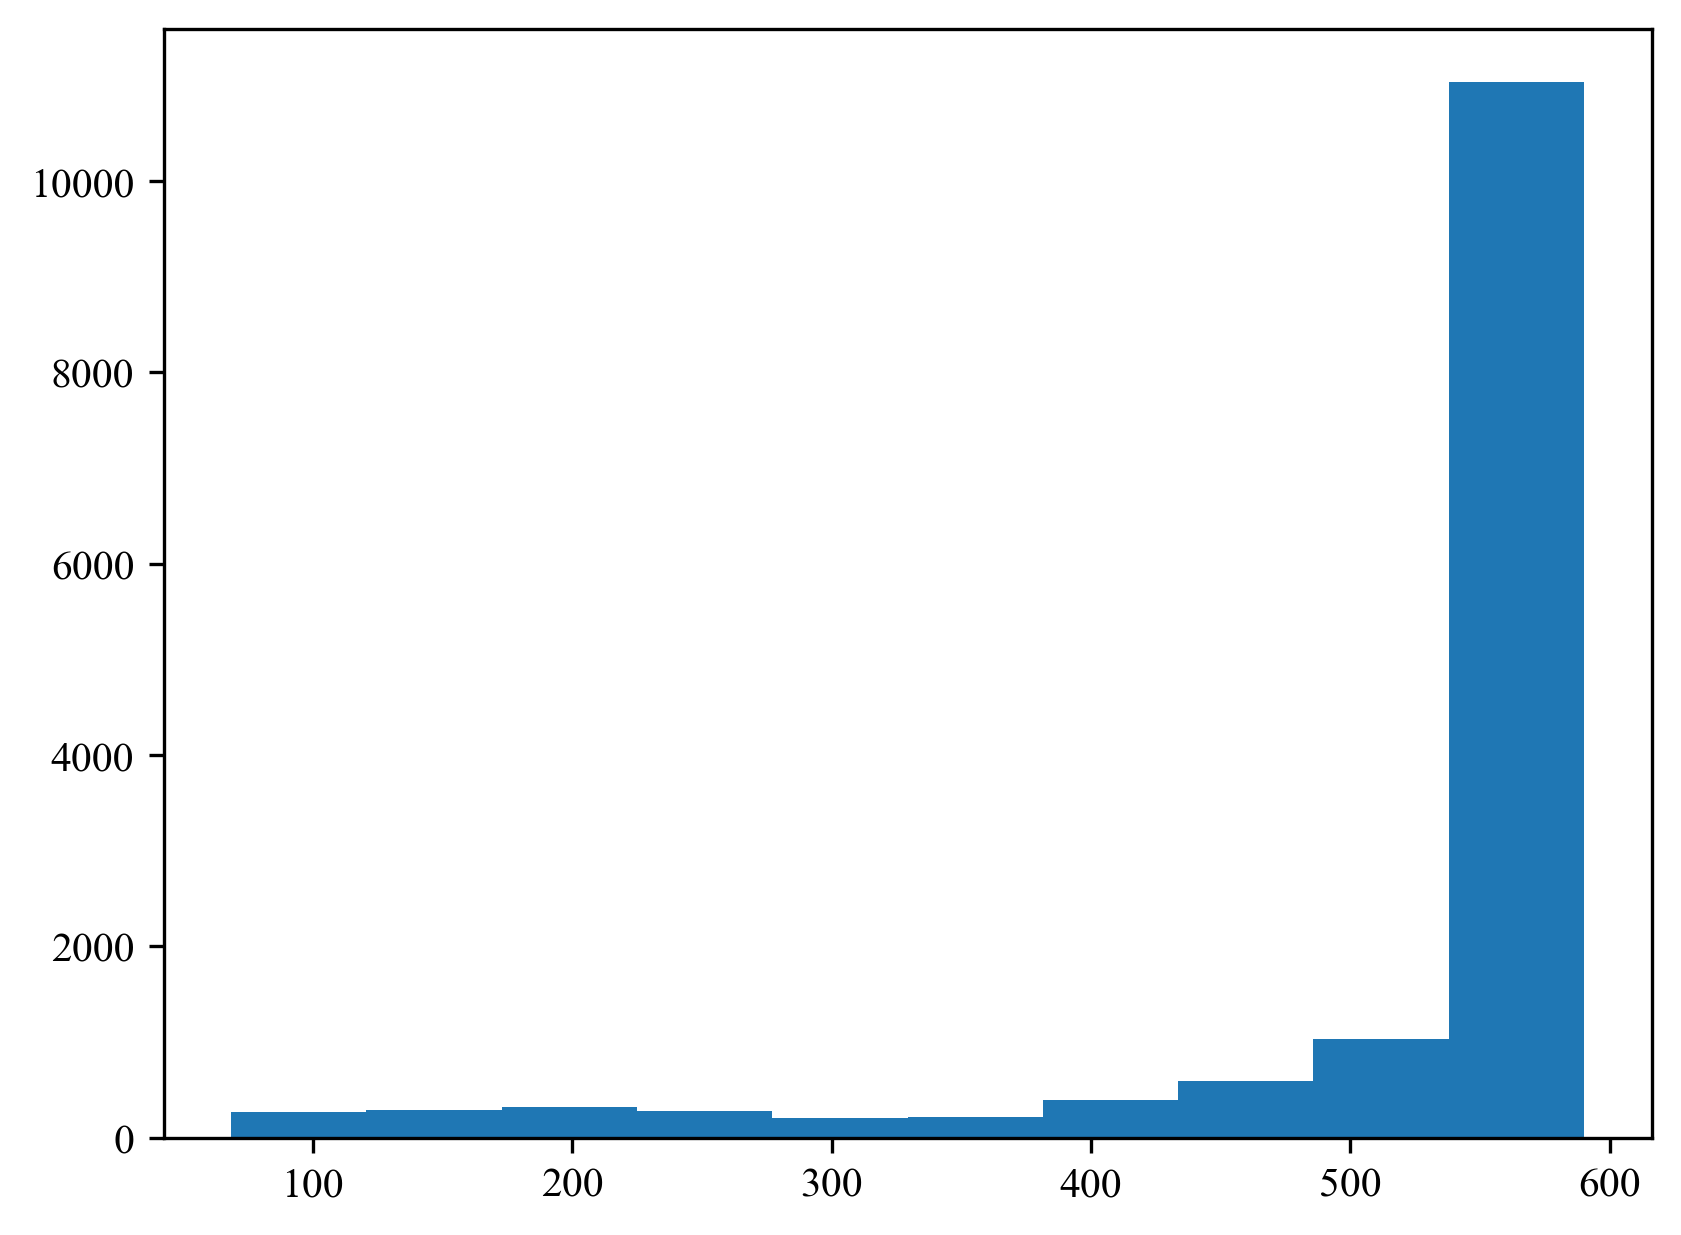

In [15]:
#Plot the histogram of the likelihoods

plt.hist(likelihood_vals)
plt.show()